In [1]:


# call __init_ to set notebook seed
import set_notebook_env
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu

from collections import defaultdict
import numpy as np

import set_notebook_env
loader, plot_utils = set_notebook_env.set_env(
    data_dir="../data/", 
    min_ratings=0, 
    max_ratings=None,
    drop_inconsistent_gender = True
)

SEED = np.random.get_state()[1][0]


Using seed: 18787288


In [2]:
loader.initial_setup()
cleaned_df = loader.add_gender_code(loader.cleaned_df)
cleaned_df.columns

Index(['avg_rating', 'avg_difficulty', 'num_ratings', 'pepper',
       'would_take_again_prop', 'num_online_ratings', 'male', 'female',
       'tough_grader', 'good_feedback', 'respected', 'lots_to_read',
       'participation_matters', 'no_skip', 'lots_of_hw', 'inspirational',
       'pop_quizzes', 'accessible', 'papers', 'clear_grading', 'hilarious',
       'test_heavy', 'few_things', 'amazing_lectures', 'caring',
       'extra_credit', 'group_projects', 'lecture_heavy', 'major',
       'university', 'state', 'gender_code'],
      dtype='object')

In [3]:
ratings = cleaned_df['avg_rating'].to_numpy()
gender = cleaned_df['gender_code'].to_numpy()

In [4]:
import numpy as np

# -----------------------------
# Helpers
# -----------------------------
def iqr(x):
    x = np.asarray(x)
    return np.quantile(x, 0.75) - np.quantile(x, 0.25)

def cohens_d(x, y):
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = x.size, y.size
    mx, my = x.mean(), y.mean()
    sx2 = np.var(x, ddof=1)
    sy2 = np.var(y, ddof=1)
    sp = np.sqrt(((nx - 1) * sx2 + (ny - 1) * sy2) / (nx + ny - 2))
    return (mx - my) / sp

def cliffs_delta(x, y):
    # δ = P(X>Y) - P(X<Y)
    x = np.asarray(x); y = np.asarray(y)
    diff = x[:, None] - y[None, :]
    n_pos = np.sum(diff > 0)
    n_neg = np.sum(diff < 0)
    return (n_pos - n_neg) / (x.size * y.size)

def ratio_stat(x, y, stat_fn):
    x = np.asarray(x); y = np.asarray(y)
    return stat_fn(x) / stat_fn(y)

def mean_difference(x, y):
    return x.mean() - y.mean()


def graph_boots(boots_list, points, cis, titles, nulls):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=False)

    for ax, boots, pt, ci, title, null in zip(
        axes, boots_list, points, cis, titles, nulls
    ):
        ax.hist(boots, bins=40, density=True, alpha=0.75)
        ax.axvline(pt, linestyle='-', linewidth=2, label='Point est.')
        ax.axvline(ci[0], linestyle='--', linewidth=2, label='95% CI')
        ax.axvline(ci[1], linestyle='--', linewidth=2)
        ax.axvline(null, linestyle=':', linewidth=2, label='Null')
        ax.set_title(title)
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

def bootstrap_ci_two_sample(
    x, y, stat_fn, B=2000, alpha=0.05, seed=SEED, return_boots=False
):
    rng = np.random.default_rng(seed)
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = x.size, y.size

    point = stat_fn(x, y)
    boots = np.empty(B)

    for b in range(B):
        xb = rng.choice(x, size=nx, replace=True)
        yb = rng.choice(y, size=ny, replace=True)
        boots[b] = stat_fn(xb, yb)

    lo, hi = np.quantile(boots, [alpha/2, 1 - alpha/2])

    if return_boots:
        return point, (lo, hi), boots
    return point, (lo, hi)



In [5]:
male = cleaned_df.loc[cleaned_df["gender_code"]==0, "avg_rating"].dropna().to_numpy()
female = cleaned_df.loc[cleaned_df["gender_code"]==1, "avg_rating"].dropna().to_numpy()

In [6]:

# -----------------------------
# 1) Cohen's d (mean effect)
# -----------------------------
d_point, d_ci, d_boots = bootstrap_ci_two_sample(
    male, female,
    stat_fn=lambda x, y: cohens_d(x, y),
    B=2000, seed=SEED, return_boots=True
)
print("Cohen's d (male - female):", d_point, "95% CI:", d_ci)

#The estimated gender difference in average ratings corresponds to a Cohen’s d 
# of 0.060 (95% CI [0.043, 0.077]), 
# indicating a statistically detectable but substantively very small pro-male difference.

Cohen's d (male - female): 0.059946114935681784 95% CI: (0.042881047214069774, 0.07704360735479983)


In [7]:

# -----------------------------
# 1) Mean difference
# -----------------------------
mean_point, mean_ci, mean_boots = bootstrap_ci_two_sample(
    male, female,
    stat_fn=lambda x, y: mean_difference(x, y),
    B=2000, seed=SEED, return_boots=True
)
print("Median Difference :", d_point, "95% CI:", d_ci)

Median Difference : 0.059946114935681784 95% CI: (0.042881047214069774, 0.07704360735479983)


In [8]:
# -----------------------------
# 3) Variance ratio (spread)
# -----------------------------
var_ratio_point, var_ratio_ci, var_boots = bootstrap_ci_two_sample(
    male, female,
    stat_fn=lambda x, y: ratio_stat(x, y, stat_fn=lambda z: np.var(z, ddof=1)),
    B=2000, seed=SEED, return_boots=True
)
print("Variance ratio Var(male)/Var(female):", var_ratio_point, "95% CI:", var_ratio_ci)

Variance ratio Var(male)/Var(female): 0.8999507134840561 95% CI: (0.877634654131638, 0.9213241956116388)


In [16]:

# -----------------------------
# 4) IQR ratio (robust spread)
# -----------------------------
iqr_ratio_point, iqr_ratio_ci, iqr_boots = bootstrap_ci_two_sample(
    male, female,
    stat_fn=lambda x, y: ratio_stat(x, y, stat_fn=iqr),
    B=2000, seed=SEED, return_boots=True
)
print("IQR ratio IQR(male)/IQR(female):", iqr_ratio_point, "95% CI:", iqr_ratio_ci)

IQR ratio IQR(male)/IQR(female): 0.8333333333333334 95% CI: (0.8333333333333334, 0.8888888888888887)


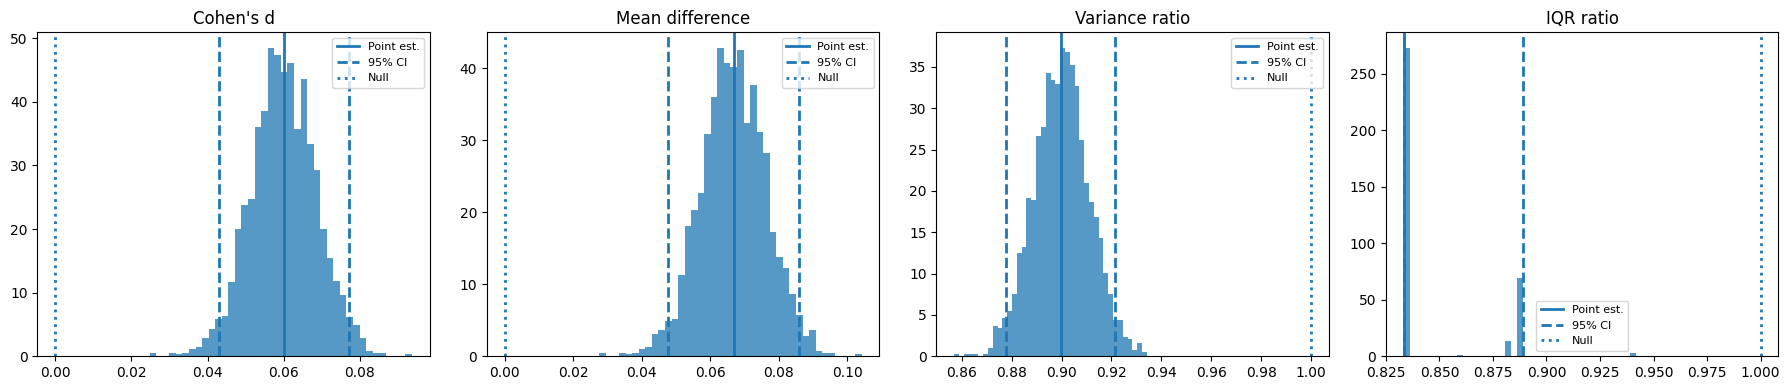

In [17]:
graph_boots(
    boots_list=[d_boots, mean_boots, var_boots, iqr_boots],
    points=[d_point, mean_point, var_ratio_point, iqr_ratio_point],
    cis=[d_ci, mean_ci, var_ratio_ci, iqr_ratio_ci],
    titles=[
        "Cohen's d",
        "Mean difference",
        "Variance ratio",
        "IQR ratio"
    ],
    nulls=[0, 0, 1, 1]
)
